In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns
from scipy import stats

if os.name == "nt":
    plt.rcParams["font.family"] = "Meiryo"
elif os.name == "posix":
    plt.rcParams["font.family"] = "Hiragino Sans"

DATA = Path('../dataset').absolute()

# 時系列データの時間依存と自己回帰

## 1. 時間依存の表現
時系列データはデータの並び順、前後関係に意味がある  
時間依存 = 時系列データの各時点間の依存関係

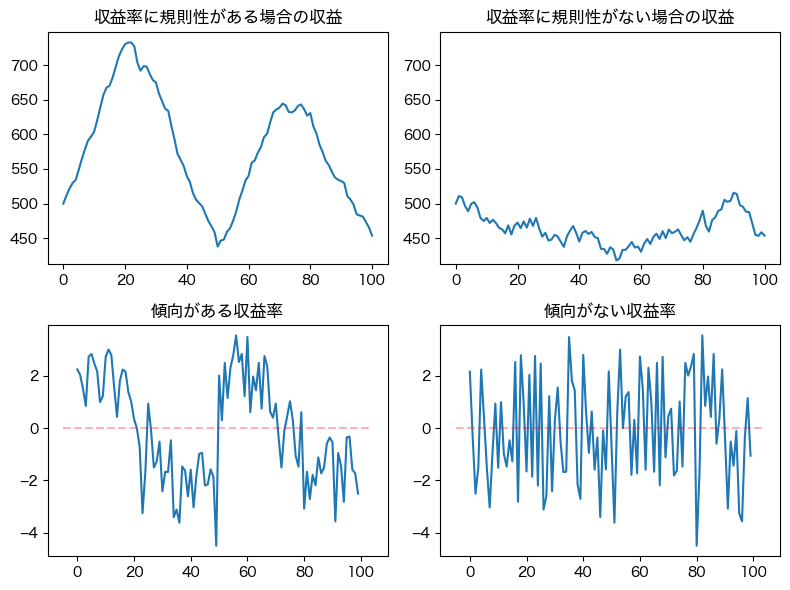

In [10]:
def price_from_return(initial_price,return_ar):
    price = [initial_price]
    for ret in return_ar:
        next = price[-1]*(1+ret/100)
        price.append(next)
    return price

# x:収益率の変動に規則性がある場合の価格変動
x_return = np.hstack([
    stats.norm.rvs(loc=2,scale=1, size=20),
    stats.norm.rvs(loc=0,scale=1, size=10),
    stats.norm.rvs(loc=-2,scale=1, size=20),
    stats.norm.rvs(loc=2,scale=1, size=20),
    stats.norm.rvs(loc=0,scale=1, size=10),
    stats.norm.rvs(loc=-2,scale=1, size=20),
])
x_price = price_from_return(500,x_return)

# y:収益率の変動に規則性がない場合の価格変動
y_return = np.random.permutation(x_return)
y_price = price_from_return(500,y_return)


fig, axes = plt.subplots(
    ncols=2,
    nrows=2,
    figsize = (8,6),
    tight_layout = True,
)

data = [[x_price,y_price],[x_return,y_return]]
name = [["収益率に規則性がある場合の収益","収益率に規則性がない場合の収益"],["傾向がある収益率","傾向がない収益率"]]

for da,na,axe in zip(data,name,axes):
    miny = 999999
    maxy = 0
    for d,n,ax in zip(da,na,axe):
        ax.plot(d)
        ax.set_title(n)
        min,max = ax.get_ylim()
        if min <= miny:
            miny = min
        if max >= maxy:
            maxy = max
    for ax in axe:
        ax.set_ylim(miny,maxy)

for ax in axes[1]:
    xmin,xmax = ax.get_xlim()
    ax.hlines(y=0,xmin=xmin,xmax=xmax,colors='r',alpha=.3,linestyles='--')

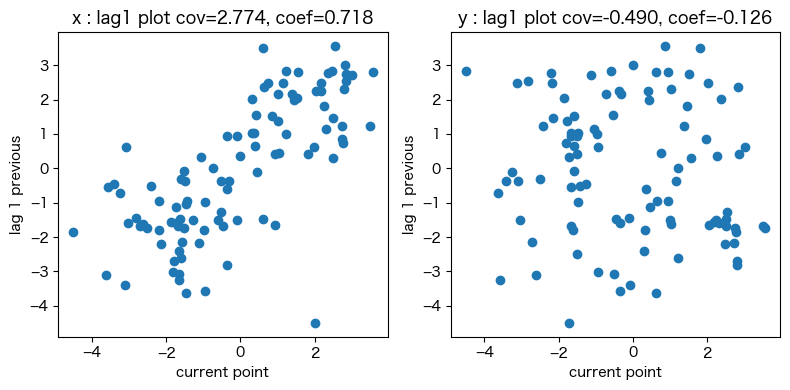

In [23]:
fig, axes = plt.subplots(
    ncols=2,
    nrows=1,
    figsize = (8,4),
    tight_layout = True,
    sharex=False,
    sharey=False,
)

for ax,rt,n in zip(axes,[x_return,y_return],['x','y']):
    x = rt[1:100]
    y = rt[0:99]
    cov = np.cov(x,y)[0,1]
    coef = np.corrcoef(x,y)[0,1]
    ax.scatter(x,y)
    ax.set_ylabel('lag 1 previous')
    ax.set_xlabel('current point')
    ax.set_title(f"{n} : lag1 plot cov={cov:.3f}, coef={coef:.3f}")

x,yの収益率はデータの並びを変えただけだが、1つ前の値との共分散、相関係数が異なる。  
xの方は明らかに「一つ前の値」と「現在の値」が正の相関関係にある = 1つ前と同じ挙動を示す傾向がある  
時系列データについて、いくつか時点をずらしたデータとの相関を"自己相関"、その相関係数を"自己相関係数"と定義する  
全部で$T$時点あるデータ$\bold{r}=(r_1, r_2, \dots r_T)$について、$h$だけずらした場合の自己相関係数は以下のように定義される  
$$
\frac{\sum_{t=h+1}^{T}{(r_t - \bar{r})(r_{t-h} - \bar{r})}}{\sum_{t=1}^{T}{(r_t - \bar{r})^2}}
$$
ここで、$\bar{r}=\frac{\sum_{t=1}^{T}{r_t}}{T}$であり、ラグ$h$の値に関係のない全体の平均である  
そのため、上記で計算したような、データ数を合わせて通常の相関係数をとる、という値と自己相関係数は異なる点に注意  
これはのちに出てくる「定常性」という概念を仮定しているためである。  
本来はある地点と別の地点の観測値はそれぞれ期待値が異なるはずであるが、1つの時点においてデータの観測が1回しかできないため、「定常性」という仮定を敷いて「各時点の期待値は全体で共通である」としている  

In [61]:
def auto_correlation_func(ar,lag):
    mu = np.mean(ar)
    n = len(ar)
    current = ar[lag:n] - mu
    lagged = ar[:n-lag] - mu
    top = np.dot(current,lagged)
    # bottom = np.sum(np.power(ar - mu, 2))
    bottom = np.dot(ar-mu, ar-mu)
    ac = top / bottom
    return ac

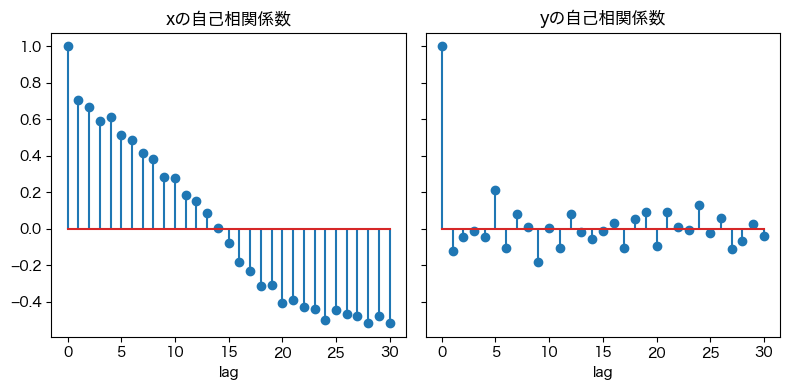

In [76]:
lag = np.arange(0,31)
fig, axes = plt.subplots(
    ncols=2,
    nrows=1,
    figsize = (8,4),
    tight_layout = True,
    sharex=True,
    sharey=True,
)

for ax,rt,n in zip(axes,[x_return,y_return],['x','y']):
    ac = np.array([auto_correlation_func(rt,l) for l in lag])
    ax.stem(lag,ac)
    ax.set_title(f'{n}の自己相関係数')
    ax.set_xlabel('lag')
plt.show()

この結果を見ると、xのデータは自己相関があるのは明らかではある。  
一方で、xについて、今回のように単純にラグをとって自己相関を求める場合、例えばlag5の自己相関係数が高いから$r_t$と$r_{t-5}$には直接の相関関係があると結論付けるのは危険である。  
なぜなら、lag1で自己相関がある時系列データは、推移律をもっているため。  

<推移律>  
lag1の自己相関を持つ、ということは、すべての時点のデータが一つ前時点のデータに影響を受けるということである  
この場合、$r_t$は$r_{t-1}$に影響を受けていて、$r_{t-1}$は$r_{t-2}$に影響を受けて、つまりは$r_t$は$r_{t-1}$を通して$r_{t-2}$からも影響を受けていて...というようにlag1の自己相関が連鎖して、"ある時点のデータは一つ前のデータを介してそれよりも過去のデータの影響を受けている"という関係にある

推移律がある場合、2以上のlagについての自己相関係数は、その間のデータも含めた相関になるので、単純に時点間の比較にならない  

この場合、自己相関を時点間で分解した偏自己相関係数を用いて考察する。  
$lag = h$の偏自己相関係数は、以下のように、共分散の線型分解の考え方から定義される。
$$
\begin{aligned}
Cov(r_t,r_{t-h}) &=
    \alpha_{1,h}Cov(r_{t-1},r_{t-h}) +
    \alpha_{2,h}Cov(r_{t-2},r_{t-h}) +
    \dots + 
    \alpha_{h-1,h}Cov(r_{t-(h-1)},r_{t-h}) + 
    \alpha_{hh}Cov(r_{t-h},r_{t-h}) \\
Cov(r_t,r_{t-h}) &=
    (r_{t}とr_{t-h}の間のhｰ1個の相関関係の和) + 
    \alpha_{hh}
\end{aligned}
$$  

上記のように考えると、$\alpha_{hh} = Cov(r_t,r_{t-h}) - (r_{t}とr_{t-h}の間のhｰ1個の相関関係の和)$が間の相関の影響を取り除いた相関係数だと解釈することができる。      

de